# Project 3: Part II
- Exploratory Data Analysis
- Modelling
- Preprocessing
- Choose and fit the model
    - Naive Bayes Multinomial Model
    - Logistic Regression Model
- Model Improvements
    - Best Naive Bayes Multinomial Model
    - Best Logistic Regression Model
- Results and Evaluation
- Conclusion and Recommendations

> <font size = 3 color = "crimson"> Do create links to the section headers   </font>

In [611]:
# import the libraries
import requests
import pandas as pd
import time
import random
import regex as re
import numpy as np
import matplotlib.pyplot as plt

from bs4 import BeautifulSoup

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB

from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords # Import the stopword list
from nltk.tokenize import RegexpTokenizer
from nltk.probability import FreqDist

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from wordcloud import WordCloud

from collections import Counter


# Exploratory Data Analysis

In [612]:
rom_df = pd.read_csv('clean_romance.csv')
rel_df = pd.read_csv('clean_relationships.csv')

In [613]:
rom_df.shape

(506, 2)

In [614]:
rel_df.shape

(506, 2)

I will use a word cloud to visually see and compare the top words used in both subreddits.
I will also remove the stop words.

In [615]:
# join up all the strings to be procressed in WordCloud
romStr = ' '.join(map(str, rom_df['selftext']))
relStr = ' '.join(map(str, rel_df['selftext'])) 

In [616]:
# Set word cloud parameters
stops = set(stopwords.words('english'))

wc_rom = WordCloud(max_words= 100,
                      width = 744,
                      height = 544,
                      background_color ='white',
                      stopwords=stops,
                      contour_width=3,
                      contour_color='steelblue',
                      min_font_size = 10).generate(romStr)

wc_rel = WordCloud(max_words= 100,
                      width = 744,
                      height = 544,
                      background_color ='white',
                      stopwords=stops,
                      contour_width=3,
                      contour_color='steelblue',
                      min_font_size = 10).generate(relStr)

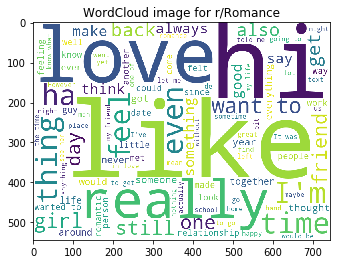

In [617]:
# plot the WordCloud image

plt.figure(figsize = (18, 4))
plt.title("WordCloud image for r/Romance")
plt.imshow(wc_rom);

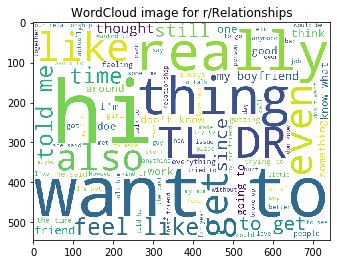

In [618]:
# plot the WordCloud image
plt.figure(figsize = (18, 4))
plt.title("WordCloud image for r/Relationships")
plt.imshow(wc_rel);

Among the top words, there are common words such as "hi" and "thing". Also it seems that the internet acronym 'TL DR' which stands for 'too long, didn't read' is commonly used in the relationship thread. I would add them into my stop word list.

In [619]:
# Add new stop words
stop_w = stopwords.words('english')
newStopWords = ['hi','thing', 'TL', 'DR', 'tl', 'dr']
stop_w.extend(newStopWords)

In [620]:
# Check stop words list
stop_w

['i',
 'me',
 'my',
 'myself',
 'we',
 'our',
 'ours',
 'ourselves',
 'you',
 "you're",
 "you've",
 "you'll",
 "you'd",
 'your',
 'yours',
 'yourself',
 'yourselves',
 'he',
 'him',
 'his',
 'himself',
 'she',
 "she's",
 'her',
 'hers',
 'herself',
 'it',
 "it's",
 'its',
 'itself',
 'they',
 'them',
 'their',
 'theirs',
 'themselves',
 'what',
 'which',
 'who',
 'whom',
 'this',
 'that',
 "that'll",
 'these',
 'those',
 'am',
 'is',
 'are',
 'was',
 'were',
 'be',
 'been',
 'being',
 'have',
 'has',
 'had',
 'having',
 'do',
 'does',
 'did',
 'doing',
 'a',
 'an',
 'the',
 'and',
 'but',
 'if',
 'or',
 'because',
 'as',
 'until',
 'while',
 'of',
 'at',
 'by',
 'for',
 'with',
 'about',
 'against',
 'between',
 'into',
 'through',
 'during',
 'before',
 'after',
 'above',
 'below',
 'to',
 'from',
 'up',
 'down',
 'in',
 'out',
 'on',
 'off',
 'over',
 'under',
 'again',
 'further',
 'then',
 'once',
 'here',
 'there',
 'when',
 'where',
 'why',
 'how',
 'all',
 'any',
 'both',
 'each

Create a function post_to_words to help with the processing of the words

In [621]:
def post_to_words(post):
    # Function to clean the words
    # The input is a single string 
    # the output is a single string          
   
    # Creation of regex patterns. Remove text that correspond to regex patterns
    #pattern_1 = '\[(.*?)\]' #square brackets
    pattern_2 = '(https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|www\.[a-zA-Z0-9][a-zA-Z0-9-]+[a-zA-Z0-9]\.[^\s]{2,}|https?:\/\/(?:www\.|(?!www))[a-zA-Z0-9]+\.[^\s]{2,}|www\.[a-zA-Z0-9]+\.[^\s]{2,})' #urls
    pattern_3 = 'romance' #subreddit(prevent data leakage)
    pattern_4 = '\/r\/' #indicative of subreddit
    pattern_5 = 'relationships'
    generic_re = re.compile("(%s|%s)" % (pattern_2, pattern_4))
    post_no_data_leakage = re.sub(r'romance', r' ', post)
    post_no_data_leakage_2 = re.sub(r'relationships', r' ', post_no_data_leakage)
    text = re.sub(generic_re, r' ', post_no_data_leakage_2)

    # Remove non-letters.
    letters_only = re.sub("[^a-zA-Z]", " ", text)
    
    # Convert to lower case, split into individual words.
    words = letters_only.lower().split()
    
    # In Python, searching a set is much faster than searching
    # a list, so convert the stopwords to a set.
    stops = set(stop_w)
    
    # Remove stopwords.
    meaningful_words = [w for w in words if not w in stops]
    
    lemmatizer = WordNetLemmatizer()
    meaningful_words2 = [lemmatizer.lemmatize(word) for word in meaningful_words]
    
    # Join the words back into one string separated by space, 
    # and return the result.
    return(" ".join(meaningful_words2))

In [622]:
# Initialize an empty list to hold the clean posts.
clean_rom_posts = ' '
clean_rel_posts = ' '

for post in rom_df['selftext']:
    
    # Convert list of posts into a single string
    clean_rom_posts = clean_rom_posts + post_to_words(post) + ' '
    
for post in rel_df['selftext']:
    
    # Convert list of posts into a single string
    clean_rel_posts = clean_rel_posts + post_to_words(post) + ' '

In [623]:
# Check the posts
clean_rom_posts

' often wonder end life anyone even need know people live fine life alone lot loner want date mind really want parent business long living keeping serious actually move meantime wondering missing much personality remains untouched due lack social life ever feel like like really true self commonly around someone actually like emotional alchemy remember walked office errand behind desk helping sat giving legal advice little portfolio time stopped awareness leaped nothingness present moment ever immersed focus becomes godlike mean notice everything like fact small intelligent dark eye would look mine le le time went heavy gaze conquered unexplored territory mind could tell thinking knew woman love man hold eye contact show confidence child play posse eye contact startle woman rarity nowadays gaze cut wide deep leaf unguarded drag treacherous shore love anyway continued presentation eye explored every inch light freckle bottom lip thick thigh everything emotion rivaled four element nature 

In [624]:
# Check the posts
clean_rel_posts

' dear community recognize coronavirus affecting globally feel best way help user condense high volume amount thread megathread two reason first seeing question asked answered ad infinitum secondly unmoderated thread contained potentially harmful advice dangerous public health megathread exclusively issue allowing coronavirus advice safety thread megathread subreddit use forum seek advice information covid offer advice protect others covid please report post comment comply covid policy information visit cdc per usual rule sub apply thread including post requirement limiting tangential comment comment contain respectful constructive advice moderation heavy ban health advice abusive user comment violate rule thank moderation team openly bisexual friend lily straight ago friend bf mark asked interested threesome pushy uncomfortable told even lily woman really type see way since friend since childhood got really really pissed said bunch hurtful thing look tattoo job lack feminine attitude 

I will now run my 2 strings of text through a tokenizer in order to break up all the words and run a word count

In [625]:
def string_to_tokens(string):
    tokenizer = RegexpTokenizer(r'\w+')
    return tokenizer.tokenize(string)

In [627]:
# "Run" Tokenizer
rom_tokens = string_to_tokens(clean_rom_posts)
rel_tokens = string_to_tokens(clean_rel_posts)

In [628]:
# Check the tokens
rom_tokens

['often',
 'wonder',
 'end',
 'life',
 'anyone',
 'even',
 'need',
 'know',
 'people',
 'live',
 'fine',
 'life',
 'alone',
 'lot',
 'loner',
 'want',
 'date',
 'mind',
 'really',
 'want',
 'parent',
 'business',
 'long',
 'living',
 'keeping',
 'serious',
 'actually',
 'move',
 'meantime',
 'wondering',
 'missing',
 'much',
 'personality',
 'remains',
 'untouched',
 'due',
 'lack',
 'social',
 'life',
 'ever',
 'feel',
 'like',
 'like',
 'really',
 'true',
 'self',
 'commonly',
 'around',
 'someone',
 'actually',
 'like',
 'emotional',
 'alchemy',
 'remember',
 'walked',
 'office',
 'errand',
 'behind',
 'desk',
 'helping',
 'sat',
 'giving',
 'legal',
 'advice',
 'little',
 'portfolio',
 'time',
 'stopped',
 'awareness',
 'leaped',
 'nothingness',
 'present',
 'moment',
 'ever',
 'immersed',
 'focus',
 'becomes',
 'godlike',
 'mean',
 'notice',
 'everything',
 'like',
 'fact',
 'small',
 'intelligent',
 'dark',
 'eye',
 'would',
 'look',
 'mine',
 'le',
 'le',
 'time',
 'went',
 'hea

In [629]:
rel_tokens

['dear',
 'community',
 'recognize',
 'coronavirus',
 'affecting',
 'globally',
 'feel',
 'best',
 'way',
 'help',
 'user',
 'condense',
 'high',
 'volume',
 'amount',
 'thread',
 'megathread',
 'two',
 'reason',
 'first',
 'seeing',
 'question',
 'asked',
 'answered',
 'ad',
 'infinitum',
 'secondly',
 'unmoderated',
 'thread',
 'contained',
 'potentially',
 'harmful',
 'advice',
 'dangerous',
 'public',
 'health',
 'megathread',
 'exclusively',
 'issue',
 'allowing',
 'coronavirus',
 'advice',
 'safety',
 'thread',
 'megathread',
 'subreddit',
 'use',
 'forum',
 'seek',
 'advice',
 'information',
 'covid',
 'offer',
 'advice',
 'protect',
 'others',
 'covid',
 'please',
 'report',
 'post',
 'comment',
 'comply',
 'covid',
 'policy',
 'information',
 'visit',
 'cdc',
 'per',
 'usual',
 'rule',
 'sub',
 'apply',
 'thread',
 'including',
 'post',
 'requirement',
 'limiting',
 'tangential',
 'comment',
 'comment',
 'contain',
 'respectful',
 'constructive',
 'advice',
 'moderation',
 'he

In [630]:
# function to remove stopwords form the tokens
def clean_tokens(tokens):
    
    for stopword in stop_w:
        for w in tokens:
            if (w == stopword):
                tokens.remove(w)
            
    return tokens

In [631]:
# function to plot top 20 works from tokens
def plot_top20_words(token1, token2):

    titles = ['Top 20 key words in r/Romance', 'Top 20 key words in r/Relationships']
    word_tokens = [token1, token2]

    fig, ax = plt.subplots(1,2,figsize=(15,10))

    for i in range(2):
    
        word_list = word_tokens[i]

        counts = dict(Counter(word_list).most_common(20))

        labels, values = zip(*counts.items())

        # sort your values in descending order
        indSort = np.argsort(values)[::-1]

        # rearrange your data
        labels = np.array(labels)[indSort]
        values = np.array(values)[indSort]

        # add labels
        ax[i].barh(labels, values, align='center')
        ax[i].invert_yaxis()  # labels read top-to-bottom  
        ax[i].set_xlabel('Word count')
        ax[i].set_title(titles[i])

    plt.show()

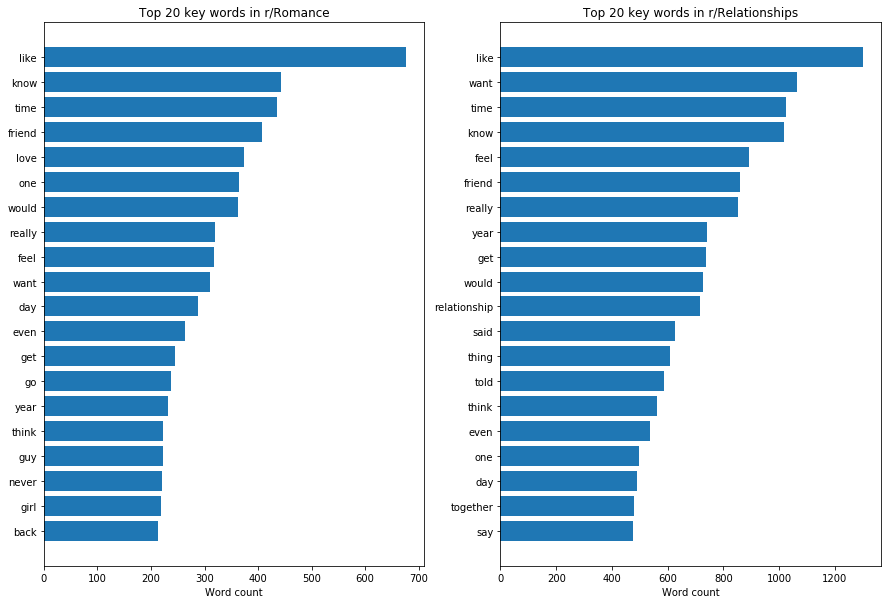

In [632]:
# Top 20 key words from the 2 subreddits
plot_top20_words(rom_tokens, rel_tokens)

Looking at the top 20 words, there are still common words between the subreddits, such as "like", "know", "time", "friend", "one", "would", "really", "feel", "want", "even", "get", "year", "thing", "think". I will add these words into my stop word list.

> <font size = 3 color = "crimson"> Do discuss about whether there are unique words for each subreddit and whether you would be able to classify properly  </font>

In [633]:
# Add new stop words
newStopWords = ["like", "know", "time", "friend", "one", "would", "really", "feel", "want", "even", "get", "year", "thing", "think"]
stop_w.extend(newStopWords)

In [634]:
# Remove new stopwords from the tokens
rom_tokens2 = clean_tokens(rom_tokens)
rel_tokens2 = clean_tokens(rel_tokens)

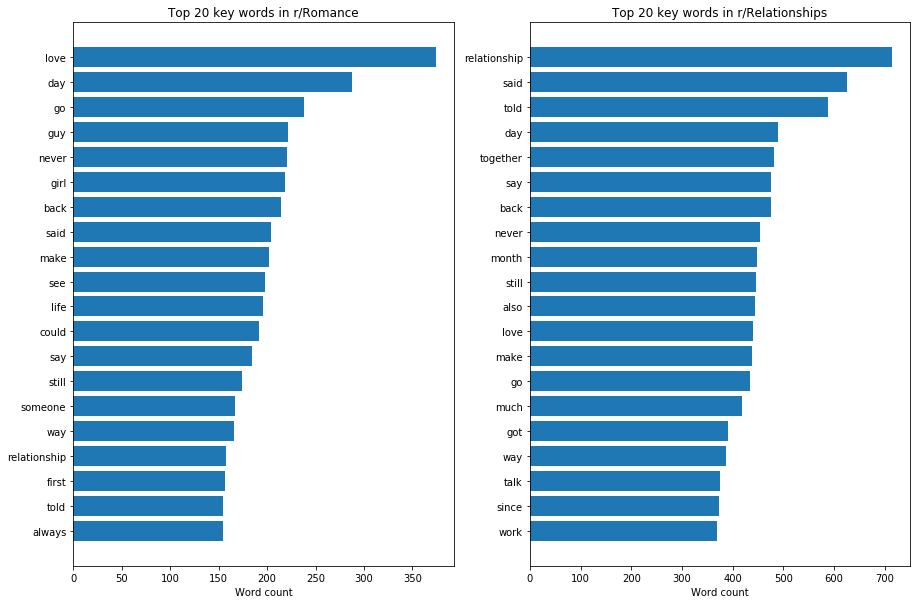

In [635]:
# Top 20 key words from the 2 subreddits
plot_top20_words(rom_tokens2, rel_tokens2)

# Preprocessing

We will now combine the 2 data sets into a single dataframe, split the data into train and test, then carry out the same cleaning of the words that I did in my EDA.

In [636]:
# Combine the romance and the relationship data for cleaning
combined_df = pd.concat([rom_df, rel_df], axis=0)

In [637]:
# Check the shape
combined_df.shape

(1012, 2)

In [638]:
# Create new column 'label' and use 0s and 1s to represent 'romance' and relationships post respectively
combined_df['label'] = combined_df['subreddit'].map({'romance': 0, 'relationships': 1})

In [639]:
# Check the dataframe
combined_df.head()

,selftext,subreddit,label
0,I often wonder if I'll end my life with anyone...,romance,0
1,Emotional Alchemy \n\nI remember when I walked...,romance,0
2,Chapter 1 - The Cruel Truth\n\nSu Jianxi hid i...,romance,0
3,I been texting this hirl for like 5 months wit...,romance,0
4,"Hey everyone, I’m a college student whose been...",romance,0


In [640]:
# Check the dataframe
combined_df.tail()

,selftext,subreddit,label
501,I (F 22) just started the job part time severa...,relationships,1
502,I have been with my GF for 3 1/2 years and hav...,relationships,1
503,We’ve been together for 3 years. Recently he’s...,relationships,1
504,TL;DR: Should I initiate our convo after we bo...,relationships,1
505,My parents on the face of it are pretty cool b...,relationships,1


In [641]:
# Set train variables X and test variables y
X = combined_df['selftext']
y = combined_df['label']

In [642]:
# Check the baseline score
y.value_counts(normalize=True)

1    0.5
0    0.5
Name: label, dtype: float64

We can choose "relationships" as the positive class. Meaning to say, if we were to randomly pick one post from the total posts, there is a 50% chance that the post is from r/Relationships. Hence, we can take this as our baseline model.

We can now split our data into train and test using train_test_split and clean X train and X test.

In [643]:
# split the data into train_set and test_set
X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    test_size = 0.25,
                                                    stratify = y,
                                                    random_state = 42)

In [644]:
# Check the shape
X_train.shape

(759,)

In [645]:
# Check the shape
X_test.shape

(253,)

In [646]:
# Initialize an empty list to hold the clean posts.
clean_X_train = []
clean_X_test = []

for post in X_train:
    
    # Clean X train
    clean_X_train.append(post_to_words(post))
    
for post in X_test:
    
    # Clean X test
    clean_X_test.append(post_to_words(post))

In [647]:
# Check X train
clean_X_train[1]

'husband married year going rough patch missing much back early day sweet note intamacy excited txt feeling wanted talk always saying he good make happy find someone online flirt miss feeling'

In [648]:
# Check X test
clean_X_test[1]

'mom f sister f length relationship w mom year mom always seems shut conversation talk happen enough notice annoyed strict mother firm hold stance need dad also picture context conversation anything say anything disagrees disagree anything usually little defensive try counter said something else arguing almost fighting talking disagreement response shut conversation say talk something kind stunned tell talk end saying anything get kind awkward say anything either anything talk today watched lighthouse mixed feeling got confused ending told show something reddit explain ending make make sense shut immediately said someone opinion tried clarify said talk got awkward always go talk sister seems super interested whatever talk try talk stuff interested always shuts feel interested say tldr talk mom stuff seems care say shuts mid conversation'

# Modeling

We will use CountVectorizer to transform the text into a matrix to count the number of word occurences.

In [649]:
# Instantiate our CountVectorizer.
cvec = CountVectorizer(max_features=500, stop_words='english')

In [650]:
# Fit our CountVectorizer on the training data and transform training data.
X_train_cvec = pd.DataFrame(cvec.fit_transform(clean_X_train).todense(), columns = cvec.get_feature_names())
# send in data series instead of dataframe

In [651]:
# Check the matrix
X_train_cvec

,able,absolutely,account,act,acting,actually,adult,advice,age,ago,...,world,worried,worry,worse,wrong,yeah,year,yes,yesterday,young
0,1,0,0,0,0,0,1,0,0,0,...,0,0,1,0,0,0,2,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,2,0,0,0,0,1,...,0,0,0,0,0,0,1,0,0,0
3,0,0,0,0,0,1,0,0,1,0,...,0,0,0,1,0,0,0,0,0,3
4,0,0,0,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
754,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,1,0,0,0
755,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
756,0,0,0,1,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
757,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [652]:
# Transform our testing data with the already-fit CountVectorizer.
X_test_cvec = pd.DataFrame(cvec.transform(clean_X_test).todense(), columns = cvec.get_feature_names())

> <font size = 3 color = "crimson"> good work in checking the word tokens generated   </font>

In [653]:
# Check the matrix
X_test_cvec

,able,absolutely,account,act,acting,actually,adult,advice,age,ago,...,world,worried,worry,worse,wrong,yeah,year,yes,yesterday,young
0,0,0,0,0,0,0,0,0,0,0,...,0,0,1,0,0,0,0,1,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
2,0,0,0,0,0,0,0,1,0,1,...,0,0,0,0,2,1,0,0,0,0
3,0,0,0,0,2,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
4,1,0,0,0,0,0,0,0,0,1,...,1,0,0,0,0,0,2,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
248,0,0,0,0,0,2,0,1,0,0,...,0,1,1,0,0,0,0,0,0,0
249,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
250,1,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
251,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,2,0,0,0


# Choose and fit the model
- Naive Bayes Multinomial
- Logistic Regression

Why I choose these models:
- Naive Bayes Multinomial is probabilistic classifier, therefore it will calculate the probability of each category using Bayes theorem, and the category with the highest probability will be output.<br>
- Logistic regression model builds a regression model to predict the probability that a given data entry belongs to the category numbered as “1”.

## Naive Bayes Multinomial Model

In [654]:
# Instantiate our model!

nb = MultinomialNB(class_prior=[0.5,0.5]) #[prob of neg class, prob of pos class]

In [655]:
# Fit our model!

nbm_model = nb.fit(X_train_cvec, y_train)

In [656]:
# Score our model on the training set.

nbm_model.score(X_train_cvec, y_train)

0.8735177865612648

In [657]:
# Score our model on the testing set.

nbm_model.score(X_test_cvec, y_test)

0.8379446640316206

Results: There is a slight overfitting to our train data. <br>
Accuracy Score on X Test (NMB1) = 0.84

## Logistic Regression Model

In [658]:
# Instantiate our model!

lr = LogisticRegression()

In [659]:
# Fit our model!

lr_model = lr.fit(X_train_cvec, y_train)

In [660]:
# Score our model on the training set.

lr_model.score(X_train_cvec, y_train)

1.0

In [661]:
# Score our model on the testing set.

lr_model.score(X_test_cvec, y_test)

0.8102766798418972

Results: Though it seems to suggest a high overfitting on the train data, however, the model is still able to return a high accuracy score on the test data. <br>
Accuracy score on X test (LR1) = 0.81

# Model improvements

We will use GridSearchCV to see if we can obtain the best hyper parameters in order to improve our models' accuracies

In [662]:
# Let's set a pipeline up with two stages:
# 1. CountVectorizer (transformer)
# 2. Naive Bayes Multinomial (estimator)

pipe_MNB = Pipeline([
    ('cvec', CountVectorizer()),
    ('nb', MultinomialNB(class_prior=[0.5,0.5]))
    
]
)

# 1. CountVectorizer (transformer)
# 2. LogisticRegression (estimator)
pipe_LR = Pipeline([
    ('cvec', CountVectorizer()),
    ('logreg', LogisticRegression(solver='liblinear', max_iter=200))
    
]
)

In [663]:
# Search over the following values of hyperparameters: (we will use the same hyperparameters for the transformer)
# Maximum number of features fit: 2000, 3000, 4000, 5000
# Minimum number of documents needed to include token: 2, 3
# Maximum number of documents needed to include token: 90%, 95%
# Check (individual tokens) and also check (individual tokens and 2-grams).

pipe_params = {
    'cvec__max_features': [2000,3000,4000,5000],
    'cvec__min_df': [2,3],
    'cvec__max_df': [0.9,0.95],
    'cvec__ngram_range': [(1,1),(1,2)]
}

## Best Multinomial Nayes Bayes model

In [664]:
# Instantiate GridSearchCV for MNB

gs_MNB = GridSearchCV(pipe_MNB, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [665]:
# Fit GridSearchCV to training data.
gs_MNB.fit(clean_X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [666]:
# Mean cross-validated score of the best_estimator
gs_MNB.best_score_

0.8366504008365284

In [667]:
# Best selected hyperparameters
gs_MNB.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [668]:
# Save best model as gs_model.
gs_model_MNB = gs_MNB.best_estimator_

In [669]:
# Score model on training set.
gs_model_MNB.score(clean_X_train, y_train)

0.922266139657444

In [670]:
# Score model on testing set.
gs_model_MNB.score(clean_X_test, y_test)

0.849802371541502

Results: Accuracy score on X test (MNB2) = 0.85, there is a small improvement from our Accuracy score on X test(MNB1)=0.84

## Best Logistic Regression model

In [671]:
gs_LR = GridSearchCV(pipe_LR, # what object are we optimizing?
                  param_grid=pipe_params, # what parameters values are we searching?
                  cv=5) # 5-fold cross-validation.

In [672]:
# Fit GridSearchCV to training data.
gs_LR.fit(clean_X_train,y_train)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('cvec',
                                        CountVectorizer(analyzer='word',
                                                        binary=False,
                                                        decode_error='strict',
                                                        dtype=<class 'numpy.int64'>,
                                                        encoding='utf-8',
                                                        input='content',
                                                        lowercase=True,
                                                        max_df=1.0,
                                                        max_features=None,
                                                        min_df=1,
                                                        ngram_range=(1, 1),
                                                        prep

In [673]:
# Mean cross-validated score of the best_estimator
gs_LR.best_score_

0.8722115719762984

In [674]:
# Best selected hyperparameters
gs_LR.best_params_

{'cvec__max_df': 0.9,
 'cvec__max_features': 2000,
 'cvec__min_df': 3,
 'cvec__ngram_range': (1, 2)}

In [675]:
# Save best model as gs_model.
gs_model_LR = gs_LR.best_estimator_

In [676]:
# Score model on training set.
gs_model_LR.score(clean_X_train, y_train)

1.0

In [677]:
# Score model on testing set.
gs_model_LR.score(clean_X_test, y_test)

0.8181818181818182

Seem likes the best model overfitted to the train data.<br>
Results: Accuracy score on X test (LR2) = 0.81, there is no improvement from our Accuracy score of X test(LR1) = 0.81

# Results and Evaluation

Our best model is Logistic Regression which returns an accuracy score of 0.84. This means it is able to accurately predict 84% the correct subbredit of the post. 

In [680]:
# Generate our predictions!

predictions = gs_model_MNB.predict(clean_X_test)

In [681]:
# Import confusion matrix.
from sklearn.metrics import confusion_matrix

# Generate confusion matrix.
# Save TN/FP/FN/TP values.

tn, fp, fn, tp = confusion_matrix(y_test, predictions).ravel()

In [682]:
# Test specificity of our model

spec = tn / (tn + fp)

print(f'Specificity: {round(spec,4)}')

Specificity: 0.748


The model has a 74.8% chance of correctly classify the post as "r/Romance"

In [683]:
# test sensitivity of our model

sens = tp / (tp + fn)

print(f'Sensitivity: {round(sens,4)}')

Sensitivity: 0.9524


The model has a 95.2% chance of correctly classify the post as "r/Relationships"

In [703]:
from sklearn.metrics import roc_auc_score

roc_auc_score(y_test, predictions)

0.8502062242219722

We have a value of 0.8502 for Receiver Operating Characteristic Area under the ROC Curve (ROC AUC).
If we have an ROC AUC of 1, our positive and negative populations are perfectly separated.

In [699]:
result_df = pd.DataFrame({'label': y_test, 'prediction': predictions, 'text':list(clean_X_test)})

In [700]:
result_df.reset_index(inplace=True, drop =True)

In [701]:
result_df[result_df['label']!=result_df['prediction']].head(10)

,label,prediction,text
9,1,0,quite embarrassing idk french ex tried time in...
12,1,0,often intimate moment closeness boyfriend self...
14,1,0,hey happened month ago towards end last semest...
18,0,1,best friend girl long love everything could ev...
20,1,0,story going make guy sound bad deep good perso...
21,0,1,im ready embark new life
24,0,1,girl known month become best friend asked kiss...
27,0,1,boyfriend together almost year usually never f...
31,0,1,amazing honestly super funny smart pretty much...
32,0,1,recently started messaging girl talked lot adm...


In [696]:
# Misclassification 1
result_df.loc[12, 'text']

'often intimate moment closeness boyfriend self conscious start laughing sometimes physical touch e g put arm around chest conscious breathing cannot relax also sometimes start conversation something requires full attention follow look response year slowly given hope go away talk well judge giving feeling rather something inside show first long term love relationship together year feeling fully seen felt heard guess scare fighting trying push away make worse make cramped able find something internet hope useful input way anyone relate name cope anyway relate nervous laughing intimate moment closeness partner'

It predicted 0 but it is 1, possibly due to "love" being a strong influencer in r/Romance

In [702]:
# Misclassification 2
result_df.loc[18, 'text']

'best friend girl long love everything could ever asked month ago said relationship recently got lot closer finally opened insecurity said never feel enough wonder relationship say generally affectionate never affectionate friend mildly cuddly lucky always act different talking excited giddy usual may wrong though sort happened different person go well wait see let go stay friend'

It predicted 1 but it is 0, possibly due to "relationship" being a strong influencer in prediting r/Relationships

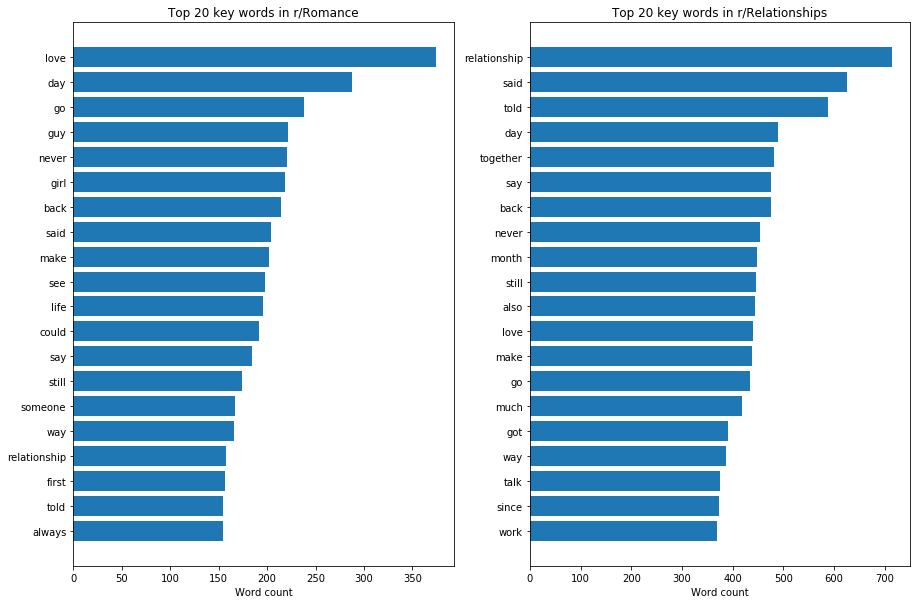

In [689]:
# top 20 key words in both categories
plot_top20_words(rom_tokens2, rel_tokens2)

> <font size = 3 color = "crimson"> The top words appear in both topics. relationship should also be included as a stop word since it is the subreddit title </font>

# Conclusion and Recommendations

My model has a 84% chance to correctly predict that the post originate from the correct subreddit. <br>

Recommendations to further improve the model:<br>
- Removing more stop words may help to further increase the accuracy of the model
- Increasing the use number of n-grams from 2-3 words to 4-5 words
- Using Term Frequency-Inverse Document Frequency (TF-IDF) Vectorizer will help to penalize words that appear frequently giving more weightage to words that appear less frequently between the documents